# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Set Variables

In [2]:
CULL_FRACTION = 1 #amount of dataset to use
TRAIN_FRACTION = 0.8 #train fraction
LOAD = False #tries to load existing model
EPOCHS = 2500
SAMPLES = 10000 #no of samples to generate
model_path = "models/model.pkl"

# Load Dataset

In [4]:
df = pd.read_csv("building_data.csv").set_index("Building Id")  
df = df.drop(columns=['Centroid', 'Post Code', 'State'])

# Pre Processing

In [5]:
cull_df = df.sample(frac=CULL_FRACTION).reset_index(drop=True)

train_data, test_data = train_test_split(cull_df, train_size=TRAIN_FRACTION)

print(train_data.shape, test_data.shape)

(320, 15) (80, 15)


# GAN Training

In [6]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train_data) 

if LOAD:
    synthesizer = CTGANSynthesizer.load(filepath=model_path)
else:
    synthesizer = CTGANSynthesizer(
        metadata,
        enforce_rounding=True,
        enforce_min_max_values=True,
        epochs=EPOCHS,
        verbose=True
    )
    synthesizer.fit(train_data)

C:\Users\raaja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sdv\single_table\base.py:92: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-2.96) | Discrim. (-0.22): 100%|█████████████████████████████████████████████| 2500/2500 [02:16<00:00, 18.37it/s]


In [7]:
samples = synthesizer.sample(
    num_rows=SAMPLES,
    batch_size=1000
)
samples

Sampling rows: 100%|██████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10035.66it/s]


,Shape,Orientation,Window to Wall Ratio,Height,Surface Area,Material,thickness,set point,Heating System,Cooling System,AC Type,Heater type,PVs,Ceiling fans,Others
0,U-Shape,North,0.55,15,242.42,Steel,0.30,21,0,1,Split AC,Gas Heating,0,1,"Microwave, Washer"
1,L-Shape,North,0.42,15,148.82,Wood,0.23,20,1,0,Split AC,Heat Pump,1,0,"Microwave, Washer"
2,Rectangular,East,0.49,12,78.44,Steel,0.33,22,1,0,VRF,Heat Pump,0,2,"Oven, Dishwasher"
3,Rectangular,East,0.34,12,50.71,Steel,0.28,22,1,1,Split AC,Gas Heating,1,0,"Microwave, Washer"
4,Rectangular,East,0.38,12,154.37,Concrete,0.22,20,0,0,VRF,Heat Pump,1,0,"Oven, Dishwasher"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,U-Shape,South,0.56,15,74.13,Concrete,0.27,22,1,1,Package AC,Gas Heating,1,0,"Microwave, Washer"
9996,L-Shape,East,0.53,15,306.70,Steel,0.27,22,1,1,Package AC,Heat Pump,1,0,"Oven, Dishwasher"
9997,Rectangular,East,0.42,18,128.85,Steel,0.23,20,1,0,Package AC,Heat Pump,0,2,"Microwave, Washer"
9998,Rectangular,South,0.57,15,85.63,Concrete,0.24,19,0,0,Package AC,Gas Heating,1,2,"Microwave, Washer"


# Evaluation

In [8]:
eval_real = test_data.copy()
eval_fake = samples.copy()

le = LabelEncoder()


for column in eval_real.select_dtypes(include=['object']).columns:
    eval_real[column] = le.fit_transform(eval_real[column])

for column in eval_fake.select_dtypes(include=['object']).columns:
    eval_fake[column] = le.fit_transform(eval_fake[column])

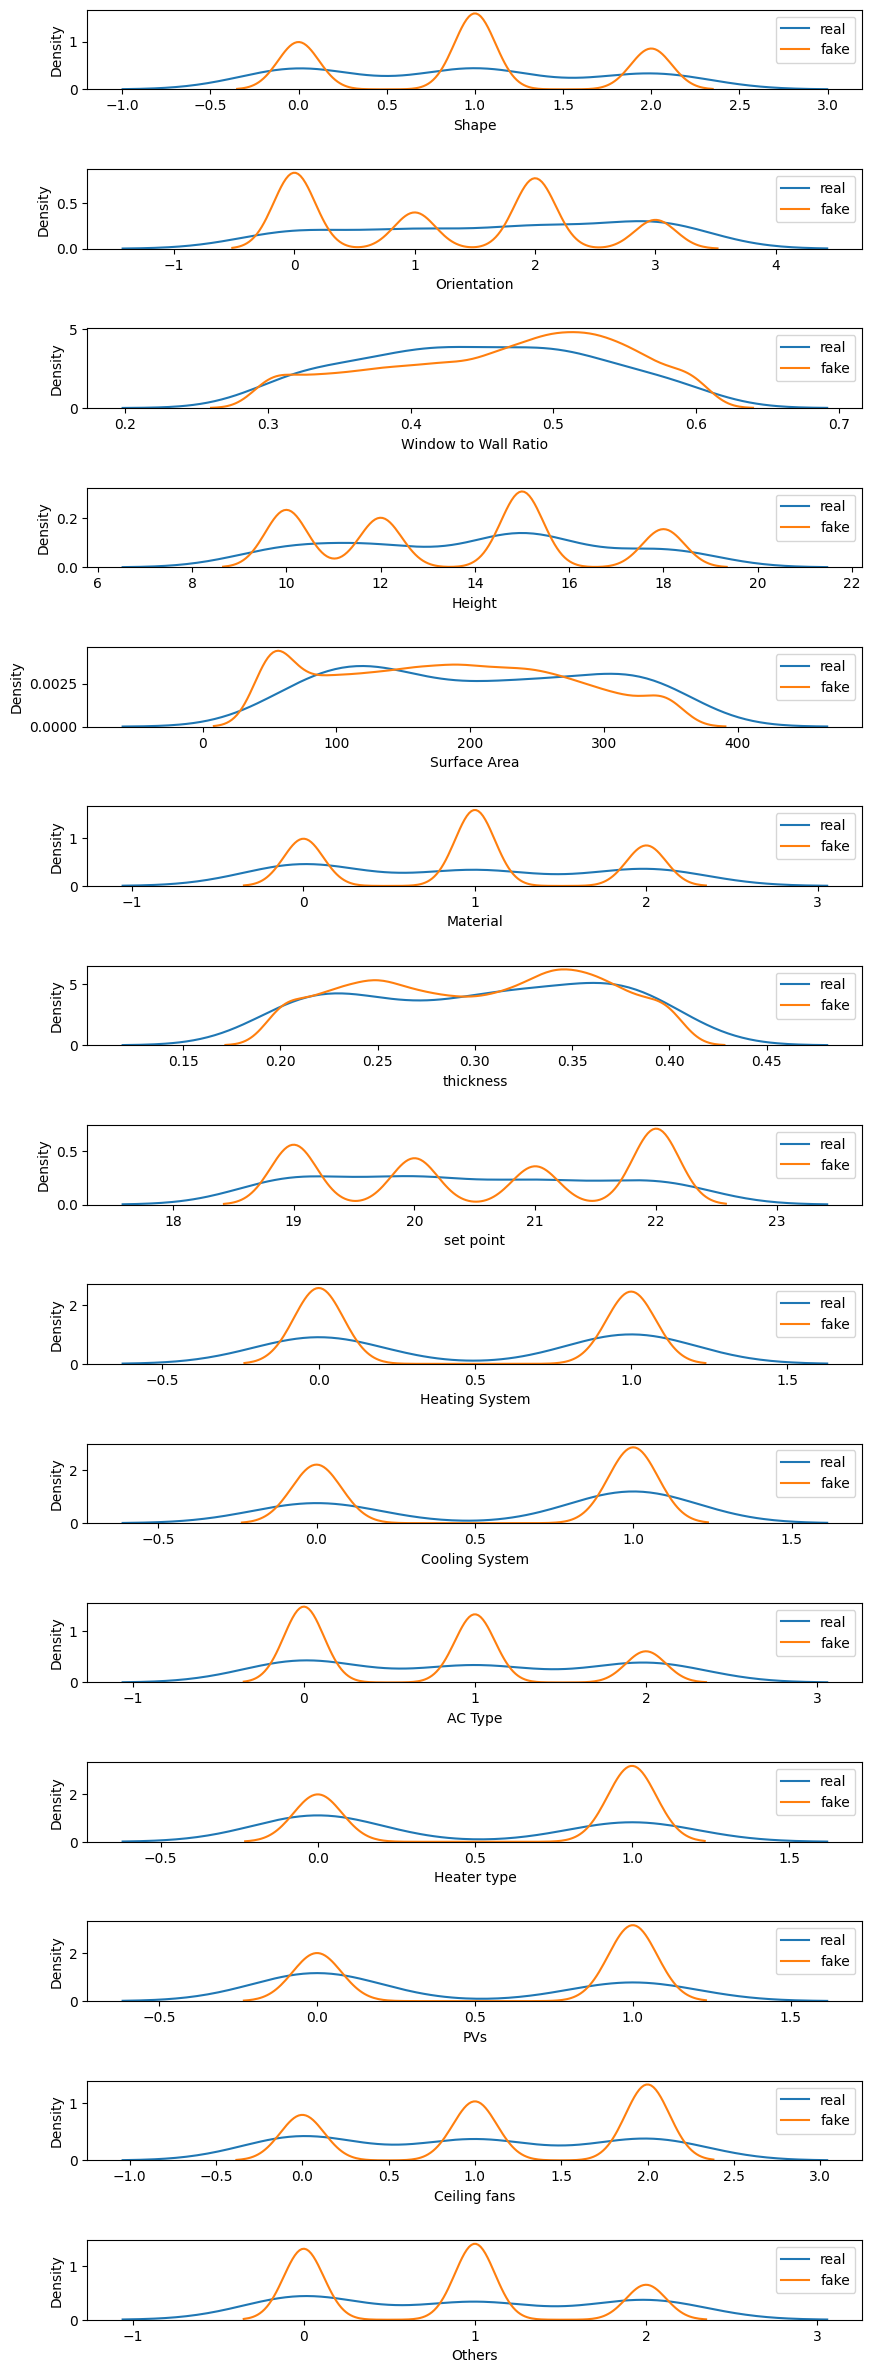

In [18]:
fig = plt.figure(figsize=(10,30))
fig.subplots_adjust(hspace=1, wspace=0.4)

for n,cat in enumerate(eval_real.columns):
    ax = fig.add_subplot(eval_real.shape[1], 1, n+1)
    sns.kdeplot(eval_real[cat], label = 'real', ax=ax)
    sns.kdeplot(eval_fake[cat], label = 'fake', ax = ax)
    plt.legend()

<Axes: >

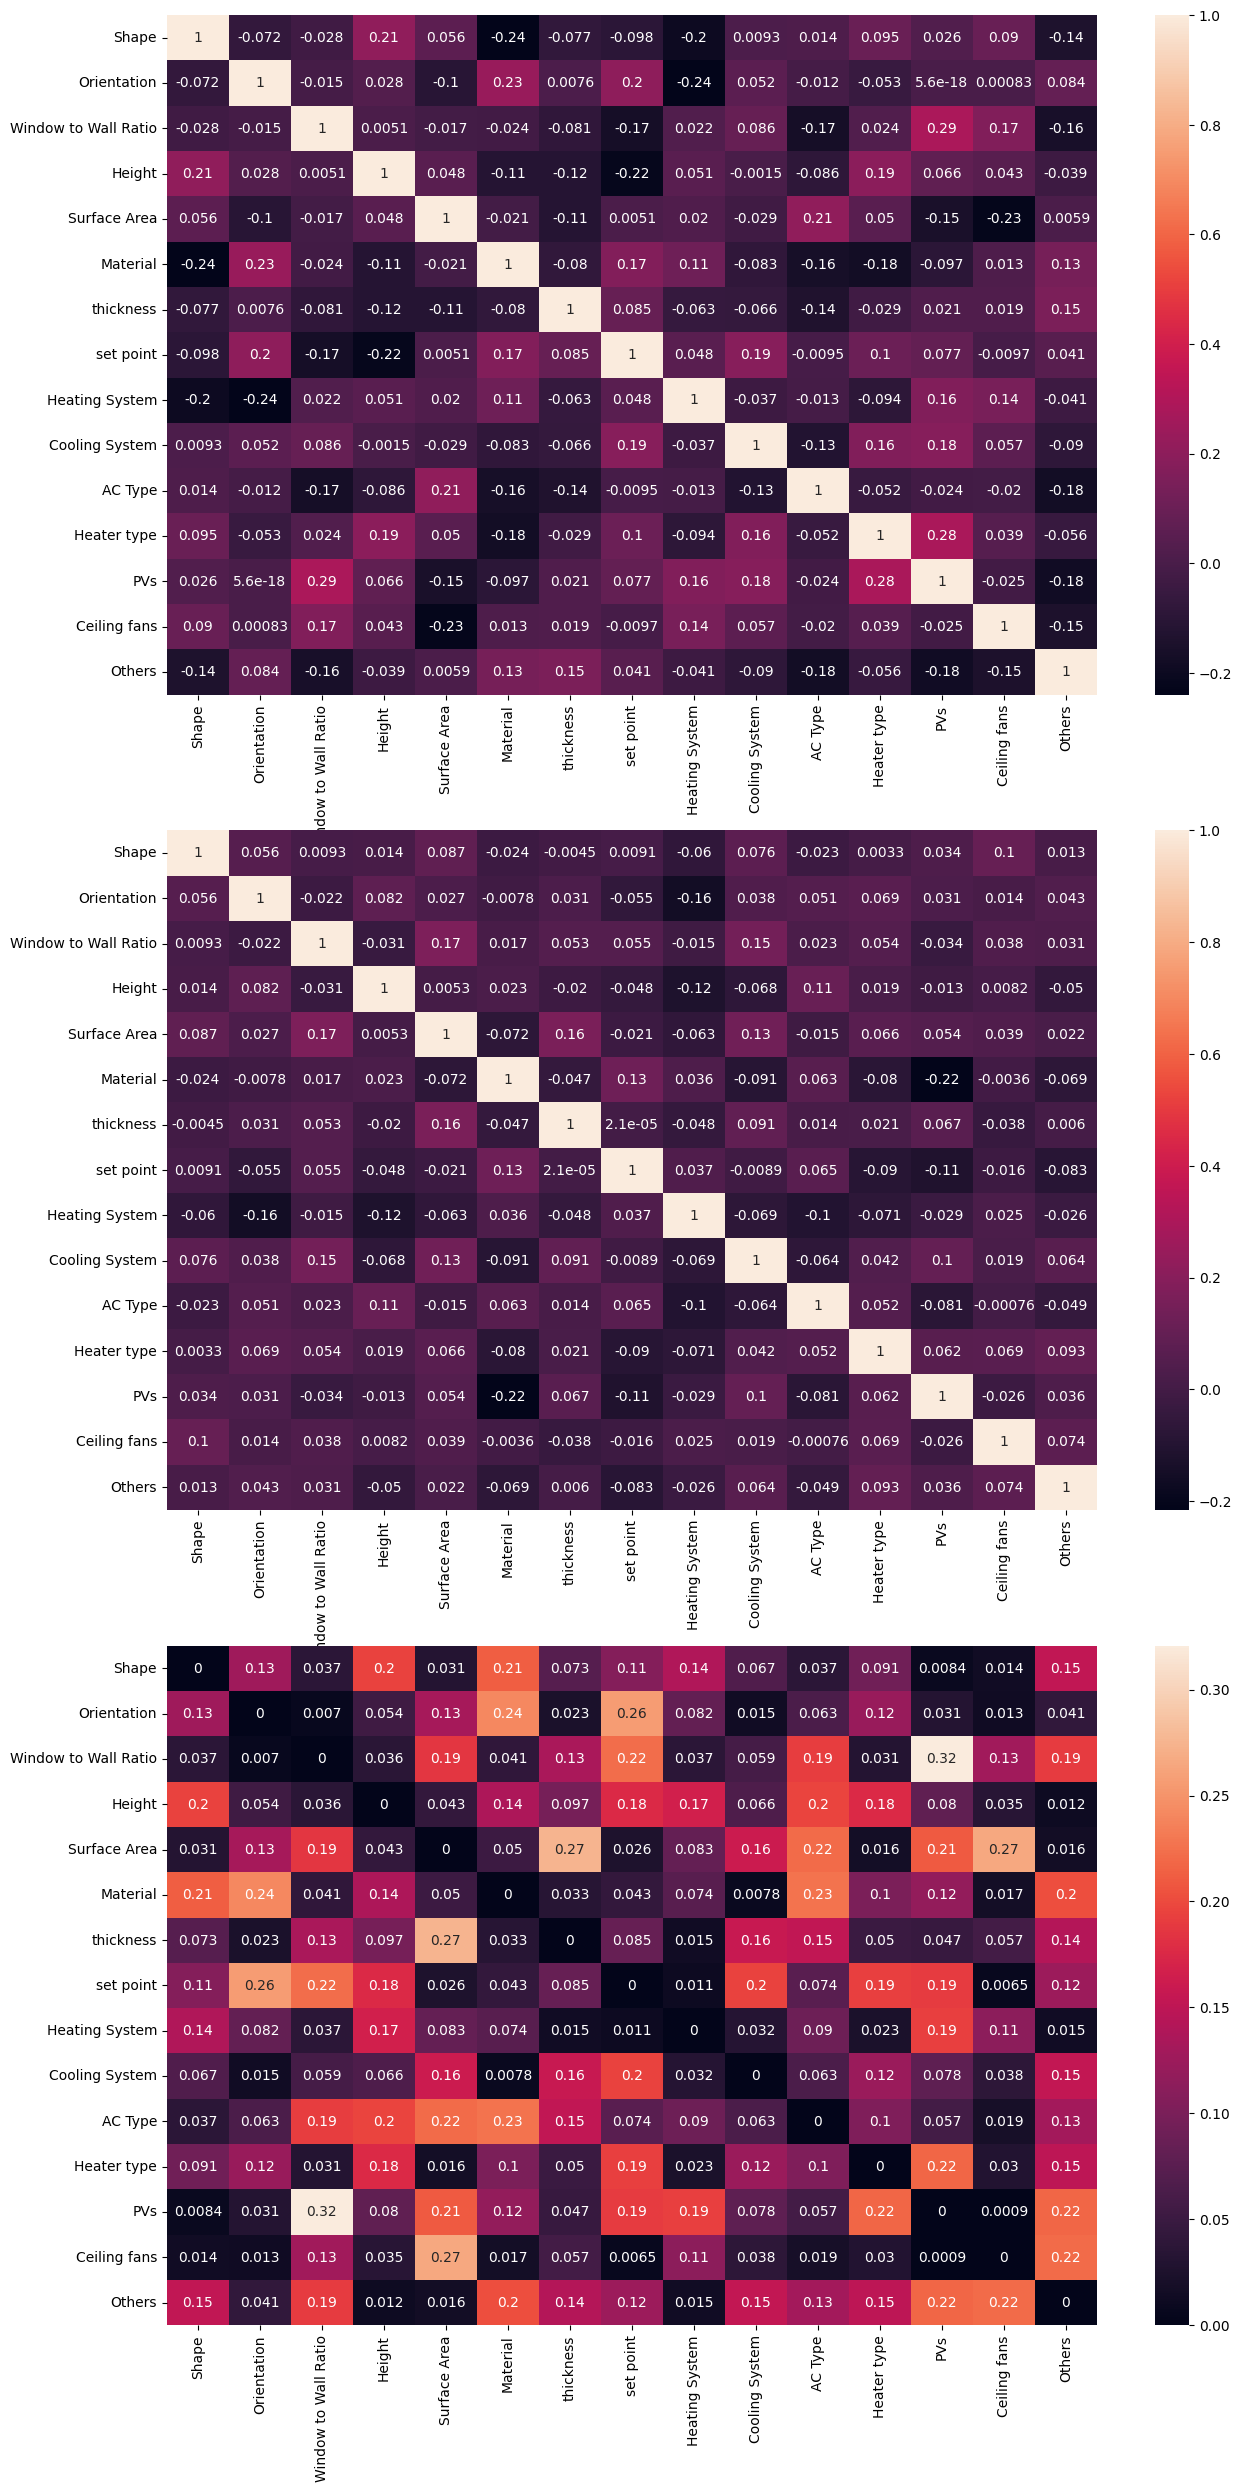

In [15]:
fig_corr = plt.figure(figsize=(15,30))
ax = fig_corr.add_subplot(3, 1, 1)
sns.heatmap(eval_real.corr(), annot=True, ax=ax)
ax = fig_corr.add_subplot(3, 1, 2)
sns.heatmap(eval_fake.corr(), annot=True, ax=ax)
ax = fig_corr.add_subplot(3, 1, 3)
sns.heatmap(abs(eval_real.corr()-eval_fake.corr()), annot=True, ax=ax)

# Save Model

In [19]:
synthesizer.save(filepath=model_path)

# Save Generated Dataset

In [20]:
samples.to_csv("generated_data.csv")